# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal gradient descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "robert"
ln1 = "gower"
fn2 = "alexandre"
ln2 = "gramfort"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_gower_robert_and_gramfort_alexandre.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 1000
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis = 0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j].copy()
        w[j] += A[:, j].T.dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:, j].dot(old_w_j - w[j])
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis = 0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j].copy()
        w[j] -= gradient[j] / lips_const[j]
        # update gradient:
        gradient += gram[j] * (w[j] - old_w_j)
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

In [6]:
n_iter = 1000

w_cyclic, f_c = cyclic_cd(A, b, n_iter)
w_greedy, f_g = greedy_cd(A, b, n_iter)

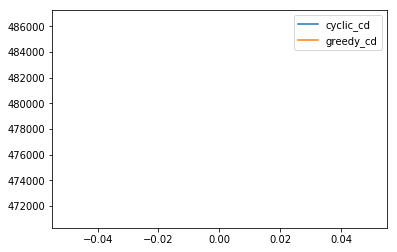

In [7]:
## to embed figures in the notebook
%matplotlib inline

nr_cycle = len(f_c)
plt.plot(np.arange(nr_cycle ), f_c, label="cyclic_cd")
plt.plot(np.arange(nr_cycle ), f_g, label="greedy_cd")
plt.legend(loc=1)
plt.show()

- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.

<b>Could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.</b>

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Show that:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert_1 (w_1)  \times \dots \times \partial \vert \cdot \vert_1 (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert_1 (w_1) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

*answer here*

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

*answer here*

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**Bonus**: show that is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$\sum_i  \frac{X_{i, j}^2}{(1 + \mathrm{e}^{-y_i X_{i, j} w_j)^2}}$$
    
(why is it better?)

Implement it in the code with a `better_lc` parameter, and compare.

In [8]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 10.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis = 0) ** 2 / 4
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
#             grad_j = 
            w[j] = soft_thresh(1, 2)
            
            # if old_w_j != w[j]:
                # Xw += 
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

SyntaxError: invalid syntax (<ipython-input-8-70e9440fd312>, line 31)

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

You can download the file here: http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv, and you should place it in the same folder as the current notebook.

In [9]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_big.csv', delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_big.csv', delimiter=',')[1:].T

print(X.shape)
print(y.shape)

(72, 7128)
(72,)


In [41]:
print (y)




[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

In [25]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(x) * (np.maximum(abs(x)-s,0))
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * norm(x, ord=1)

In [54]:
def grad_logreg(x):
    """Logistic gradient"""
    c = np.exp(- y * X.dot(x))
    return  np.sum(- y * X.T * c / (1 + c), axis=1)

# def loss_logreg(x, lbda):
#     yXx = y * np.dot(X, x)
#     return np.mean(np.log(1. + np.exp(- yXx))) + lbda * norm(x) ** 2 / 2.


def loss_logreg(x):
    yXx = y * np.dot(X, x)
    return np.sum(np.log(1. + np.exp(- yXx)))

# def lipschitz_logreg(lbda):
#     return norm(X, ord=2) ** 2 / (4. * n_features) + lbda


# def lipschitz_logreg(lbda):
#     return norm(X, ord=2) ** 2 / (4.) + lbda


def lipschitz_logreg(X):
    return norm(X, ord=2) ** 2 / (4.)

In [27]:

# def grad_logreg(x):
#     """Logistic gradient"""
#     c = np.exp(- b_log * A_log.dot(x))
#     return 1. / n_samples * np.sum(- b_log * A_log.T * c / (1 + c), axis=1)


# def lip_logreg(A):
#     """Lipschitz constant for logistic loss"""
#     return norm(A, ord = 2) ** 2. / (4. * n_samples)

# step = 1 / lip_logreg(A_log)
# s=0.05


# def loss_logreg(x):
#     """Logistic loss"""
#     return 1. / n_samples * np.sum(np.log(1. + np.exp(-b_log * A_log.dot(x))))




In [37]:
print (step)

0.0006843439237722282


In [29]:
# def ista(x0, f, grad_f, g, prox_g, step, lambd, n_iter=50,
#          verbose=True):
#     """Proximal gradient descent algorithm
#     """
#     x = x0.copy()
#     x_new = x0.copy()
#     print(x)
#     # objective history
#     objectives = []
#     # Current objective
#     obj = f(x, lambd) + g(x, lambd)
#     objectives.append(obj)
#     if verbose:
#         print("Lauching ISTA solver...")
#         print(' | '.join([name.center(8) for name in ["it", "obj"]]))
#     for k in range(n_iter + 1):
#         x = prox_g(x - step * grad_f(x), lambd)
        
#         obj = f(x, lambd) + g(x, lambd)
#         objectives.append(obj)
#         if k % 10 == 0 and verbose:
#             print(' | '.join([("%d" % k).rjust(8), 
#                               ("%.2e" % obj).rjust(8)]))
#     return x, objectives

In [50]:
def ista(x0, f, grad_f, g, prox_g, step, lambd, n_iter=50,
         verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    print(x)
    # objective history
    objectives = []
    # Current objective
    obj = f(x) + g(x, lambd)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]]))
    for k in range(n_iter + 1):
        x = prox_g(x - step * grad_f(x), lambd)
        
        obj = f(x) + g(x, lambd)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8)]))
    return x, objectives



In [51]:
# print (lambd)

# def lip_logreg(A):
#     """Lipschitz constant for logistic loss"""
#     return norm(A, ord = 2) ** 2. / (4. * n_samples)

In [55]:

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.


lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lambd = lambda_max / 10.  

n_samples = X.shape[0]
n_features = X.shape[1]
x_init = np.zeros(n_features)
step = 1 / lipschitz_logreg(X)


print (step)

9.532453622789366e-06


In [56]:
nr_iter = 1000
ref_x, ref_objectives = ista(x_init, loss_logreg, grad_logreg, lasso, prox_lasso, step, lambd, nr_iter, False)
print ('The precise minimum for ista is: ',  ref_objectives[-1])
print ('The precise minimizer for ista is: ',  ref_x)

[0. 0. 0. ... 0. 0. 0.]
The precise minimum for ista is:  49.90659700031606
The precise minimizer for ista is:  [-0. -0. -0. ... -0. -0. -0.]


In [ ]:


A, b = simu_linreg(coefs)
step = 1 / lip_linreg(A)
ref_x, ref_objectives, ref_errors = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 1000, coefs, False)
print ('The precise minimum for fista is: ',  ref_objectives[-1])
print ('The precise minimizer for fista is: ',  ref_x)


def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_g(x - step * grad_f(x), s)
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors